#Modelling notebook
This notebook uses data frame which is created in `feature-engineering notebook` and then segments the users using K Means. It then tries to predict which segments will uninstall the movies within next two days. <br>
We have already created  a file **uninstall_unique** which contains the users who have uninstalled the app in  `feature-engineering notebook`.

##Mount Google drive in Colab where data is stored 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Import necessary python libraries<br>


In [0]:
import pandas as pd
#!pip install ray
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

## Load the datasets


In [0]:
final_df = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/final_df.csv',index_col=0)
uninstall_unique = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/uninstall_unique.csv',index_col=0)
final_df.drop(['actual','predicted'],axis=1,inplace=True)

### Cell Description
Below cell creates two additional features `watch_rate` and `launch_rate` i.e how many times a user watches a video per day and how many times he launches the app per day.


In [0]:
vidstarted = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/VideoStarted.csv')
genres = vidstarted.Genre.unique()

In [0]:
final_df['launched_days'] = final_df['launched_days'].replace({0:0.0001})
final_df['launch_rate'] = final_df['installed_times']/final_df['launched_days']

final_df['watched_days'] = final_df['watched_days'].replace({0:0.0001})
final_df['vids_watched'] = final_df.loc[:,genres].sum(axis=1)
final_df['watch_rate'] = final_df['vids_watched']/final_df['watched_days']

#final_df.watch_rate = final_df.watch_rate.replace({np.inf:0})
final_df = final_df.fillna(0)
final_df.drop(['launched_days','watched_days'],axis=1,inplace=True)

### Cell Description
Below cell creates 4 clusters of users. We used PCA to plot the clusters in 2d plot.


Text(0.5, 1.0, 'segmentation by KMeans')

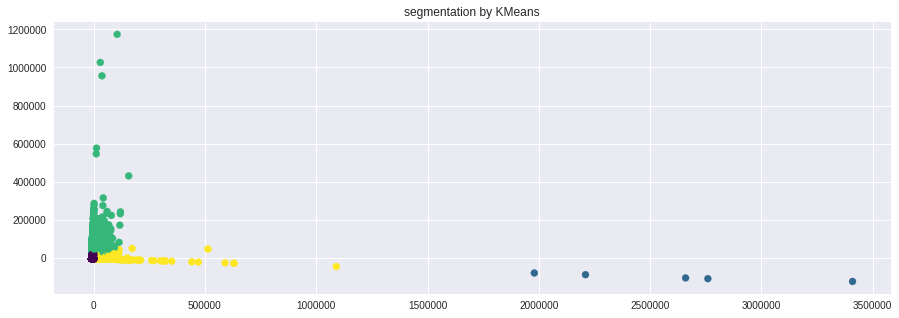

In [31]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
km = KMeans(n_clusters=4,random_state=42)
#km = MiniBatchKMeans(n_clusters=4)
km.fit(final_df)
labels = km.predict(final_df)

from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=42)
res = pca.fit_transform(final_df)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,5))
plt.scatter(res[:,0],res[:,1],c=labels,cmap='viridis')
sns.despine(bottom=True, left=True)
plt.title('segmentation by KMeans')

In [36]:
#print(abs( pca.components_ ))
pca.explained_variance_ratio_

array([0.85825654, 0.14168809])

In [27]:
final_df['predicted'] = labels
final_df['predicted'].value_counts()

0    121902
3     21654
2      6439
1         5
Name: predicted, dtype: int64

###Cell Description
Below cell creates a list `actual` which stores 0 if user uninstalled the app else it stores 1. This will be used as ***Yactual*** during
evaluation. <br>
We also make the predictions on the basis of clustering and store it in `predicted`. This will be used as ***Ypred***. 

In [0]:
#actual = [1 if uid not in uninstall_unique.UserId.tolist() else 0 for uid in tqdm(final_df.index.tolist())]
final_df['actual'] = actual
final_df['predicted'] = labels
final_df['predicted'] = final_df['predicted'].replace({0:1,1:0,2:0,3:0})

###Cell Description
Below cell evaluates the model. 

In [29]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,confusion_matrix,recall_score

f_score = f1_score(final_df['actual'],final_df['predicted'])
acc_score = accuracy_score(final_df['actual'],final_df['predicted'])

prec_score = precision_score(final_df['actual'],final_df['predicted'])
rec_score = recall_score(final_df['actual'],final_df['predicted'])

print('f1_score:'+str(f_score))
print('recall_score:'+str(rec_score))
print('precision_score:'+str(prec_score))
print('accuracy_score:'+str(acc_score))
print('confusion_matrix:')

confusion_matrix(final_df['actual'],final_df['predicted'],labels=[0,1])

f1_score:0.4576107667446516
recall_score:0.8635474033953848
precision_score:0.3112828337517022
accuracy_score:0.40032
confusion_matrix:


array([[22102, 83956],
       [ 5996, 37946]])

In [190]:
temp = [1]*150000
f_score = f1_score(final_df['actual'],temp)
acc_score = accuracy_score(final_df['actual'],temp)
prec_score = precision_score(final_df['actual'],temp)
rec_score = recall_score(final_df['actual'],temp)

print('f1_score:'+str(f_score))
print('precision_score:'+str(prec_score))
print('recall_score:'+str(rec_score))
print('accuracy_score:'+str(acc_score))
print('confusion_matrix:')

confusion_matrix(final_df['actual'],temp,labels=[0,1])


f1_score:0.4531457858535026
precision_score:0.2929466666666667
recall_score:1.0
accuracy_score:0.2929466666666667
confusion_matrix:


array([[     0, 106058],
       [     0,  43942]])

In [41]:
final_df.actual.value_counts()

0    106058
1     43942
Name: actual, dtype: int64